In [2]:
import numpy as np 
import pandas as pd 
from scipy import signal
import matplotlib.pyplot as plt 
import math
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from dataset_tools import Dataset, lowpass_filter, extract_sensors, extract_features

# Loading & Extracting

In [3]:
person1 = Dataset('dataset/dataset_1.txt')
person2 = Dataset('dataset/dataset_2.txt')
number_of_datasets = 19
everyone = []

In [5]:
for dataset_num in range(1,number_of_datasets+1):
    dataset = Dataset(f'dataset/dataset_{dataset_num}.txt')
    everyone.append(dataset)

| 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10| 11| 12| 13| 14|15 | 16| 17|   18| 19| 20| 21| 22| 23| 24|
|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|---|
|Wrist:A1(X)|A2(Y)|A3(Z)|G1(x)|G2(Y)|G3(Z)|Chest:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Hip:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Ankle:A1(X)|A2(Y)|A3(Z)|G1(X)|G2(Y)|G3(Z)|Type|

# Visualising

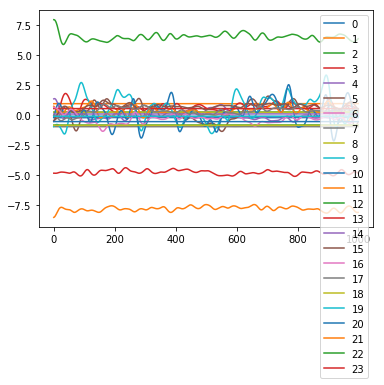

In [51]:
person1.sitting['all'][:1000].plot()

# Filtering

/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


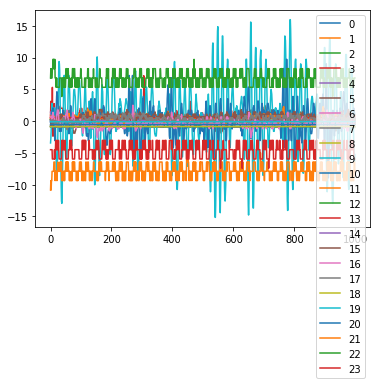

In [6]:
lowpass_filter(person2.data_frame, 4, 5)
person1.extract_sensors(300)
person1.sitting['all'][:1000].plot()

In [7]:
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    lowpass_filter(dataset.data_frame, order=4, cutoff=5)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

# Feature Extraction

In [35]:
window_size = 1000
#instantiating the testing and training set
all_train, all_test = person1.extract_all_features([np.max, np.min], window_size)
for idx, dataset in enumerate(everyone):
    print(idx, end=' ')
    if idx==0: continue
    d_train, d_test = dataset.extract_all_features([np.max, np.min], window_size)
    all_train.append(d_train)
    all_test.append(d_test)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 

# Training & Testing Preprocessing

In [23]:
training_sensors = all_train.loc[:,all_train.columns !='activity']
training_activities = all_train.loc[:,:'activity':-1]
testing_sensors = all_test.loc[:,all_test.columns !='activity']
testing_activities = all_test.loc[:,:'activity':-1]

In [24]:
len(training_sensors)
len(training_activities)
len(testing_sensors)
len(testing_activities)

294

In [25]:
scaler = preprocessing.StandardScaler().fit(training_sensors)
training_sensors = scaler.transform(training_sensors)
testing_sensors = scaler.transform(testing_sensors)

# KNN

In [26]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(training_sensors, training_activities.values.ravel())

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

In [27]:
predict_activities = knn.predict(testing_sensors)
print('Accuracy: ', accuracy_score(testing_activities, predict_activities))
print(confusion_matrix(testing_activities, predict_activities))

Accuracy:  0.9387755102040817
[[ 3  0  0  0  0  0  0  0  1  0  0  4  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3 27  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  0  0  5  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 18  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 64  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 30]]


# SVC

In [30]:
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-1,1e-2, 1e-3, 1e-4],
                     'C': [1e-3, 1e-2, 1e-1, 1, 10, 100, 100]},
                    {'kernel': ['linear'], 'C': [1e-3, 1e-2, 1e-1, 1, 10, 100]}]
acc_scorer = make_scorer(accuracy_score)
grid_obj  = GridSearchCV(SVC(), tuned_parameters, cv=10, scoring=acc_scorer)
grid_obj  = grid_obj.fit(training_sensors, training_activities.values.ravel())

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [34]:
clf = grid_obj.best_estimator_
print('best clf:', clf)
clf.fit(training_sensors, training_activities.values.ravel())
y_pred = clf.predict(testing_sensors)
print('Accuracy: ', accuracy_score(testing_activities, y_pred))
print(confusion_matrix(testing_activities, y_pred))

best clf: SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
Accuracy:  0.9591836734693877
[[ 4  0  0  0  0  0  0  0  1  0  0  3  0]
 [ 0 30  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  2 28  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  5  0  0  0  0  0  0  0  3  0]
 [ 0  0  0  0 14  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 14  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 14  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 21  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0 31  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 13  0  1]
 [ 0  0  0  0  0  0  0  0  0  0  0 64  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0 29]]
